In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import argparse
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import copy
import random
import time
import math

import utils
import models

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(10)

In [3]:
def sample_from_matrix(data, number):
    number_of_rows = data.shape[0]
    indices = np.random.choice(number_of_rows, number)
    return data[indices, :]

def norm_tsne(data):
    min, max = np.min(data, 0), np.max(data, 0)
    return data / (max-min)

tsne = TSNE(init='pca', random_state=0)

In [4]:
sns.set_style("whitegrid")

In [5]:
import utils
data, labels = utils.load_data('seed3')

In [6]:
source_data, source_label = data[0], labels[0]
target_data, target_label = source_data.pop(), source_label.pop()

In [7]:
# sample 100 data
source_tsne_data = []
for i in range(len(source_data)):
    source_tsne_data.append(sample_from_matrix(source_data[i], 100))
target_tsne_data = sample_from_matrix(target_data, 100)

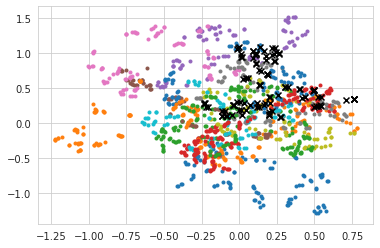

In [8]:
for i in range(len(source_data)):
    trans_data = tsne.fit_transform(source_tsne_data[i])
    trans_data = norm_tsne(trans_data)
    plt.scatter(trans_data[:,0], trans_data[:,1], marker=".")

trans_t_data = tsne.fit_transform(target_tsne_data)
trans_t_data = norm_tsne(trans_t_data)
plt.scatter(trans_t_data[:,0], trans_t_data[:,1], marker="x", c='black')


In [9]:
# sample 100 data
source_tsne_data = []
for i in range(len(source_data)):
    source_tsne_data.append(sample_from_matrix(source_data[i], 100))
target_tsne_data = sample_from_matrix(target_data, 100)

In [10]:
for i in range(len(source_data)):
    source_data[i] = utils.norminy(source_data[i])
target_data = utils.norminy(target_data)

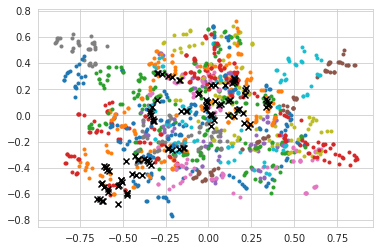

In [11]:
for i in range(len(source_data)):
    trans_data = tsne.fit_transform(source_tsne_data[i])
    trans_data = norm_tsne(trans_data)
    plt.scatter(trans_data[:,0], trans_data[:,1], marker=".")

trans_t_data = tsne.fit_transform(target_tsne_data)
trans_t_data = norm_tsne(trans_t_data)
plt.scatter(trans_t_data[:,0], trans_t_data[:,1], marker="x", c='black')


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DANNet():
    def __init__(self, model=models.DAN(), source_loader=0, target_loader=0, batch_size=64, iteration=10000, lr=0.001, momentum=0.9, log_interval=10):
        self.model = model 
        self.model.to(device)
        self.source_loader = source_loader
        self.target_loader = target_loader 
        self.batch_size = batch_size
        self.iteration = iteration
        self.lr = lr
        self.momentum = momentum
        self.log_interval = log_interval

    def __getModel__(self):
        return self.model

    def train(self):
        best_model_wts = copy.deepcopy(self.model.state_dict())
        source_iter = iter(self.source_loader)
        target_iter = iter(self.target_loader)
        correct = 0

        for i in range(1, self.iteration+1):
            self.model.train()
            LEARNING_RATE = self.lr
            if (i - 1) % 100 == 0:
                print("Learning rate: ", LEARNING_RATE)
            optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
            
            try:
                source_data, source_label = next(source_iter)
            except Exception as err:
                source_iter = iter(self.source_loader)
                source_data, source_label = next(source_iter)
            try:
                target_data, _ = next(target_iter)
            except Exception as err:
                target_iter = iter(self.target_loader)
                target_data, _ = next(target_iter)
            source_data, source_label = source_data.to(device), source_label.to(device)
            target_data = target_data.to(device)
            
            optimizer.zero_grad()
            source_prediction, mmd_loss, _ = self.model(source_data, data_tgt=target_data)
            cls_loss = F.nll_loss(F.log_softmax(source_prediction, dim=1), source_label.squeeze())
            gamma = 2 / (1 + math.exp(-10 * (i) / (iteration))) - 1
            loss = cls_loss + gamma * mmd_loss
            loss.backward()
            optimizer.step()
            if i % log_interval == 0:
                print('Iter: {} [({:.0f}%)]\tLoss: {:.6f}\tsoft_loss: {:.6f}\tmmd_loss {:.6f}'.format(
                    i, 100.*i/self.iteration, loss.item(), cls_loss.item(), mmd_loss.item()
                    )
                )
            if i % (log_interval * 20) == 0:
                t_correct = self.test(i)
                if t_correct > correct:
                    correct = t_correct
                best_model_wts = copy.deepcopy(self.model.state_dict())
                print('to target max correct: ', correct.item(), "\n")
        self.model.load_state_dict(best_model_wts)
        return 100. * correct / len(self.target_loader.dataset), self.model

    def test(self, i):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.target_loader:
                data = data.to(device)
                target = target.to(device)
                preds, mmd_loss, _ = self.model(data, data)
                test_loss += F.nll_loss(F.log_softmax(preds, dim=1), target.squeeze(), reduction='sum').item()
                pred = preds.data.max(1)[1]
                correct += pred.eq(target.data.squeeze()).cpu().sum()
            test_loss /= len(self.target_loader.dataset)
        return correct

class MSMDAER():
    def __init__(self, model=models.MSMDAERNet(), source_loaders=0, target_loader=0, batch_size=64, iteration=10000, lr=0.001, momentum=0.9, log_interval=10):
        self.model = model
        self.model.to(device)
        self.source_loaders = source_loaders
        self.target_loader = target_loader
        self.batch_size = batch_size
        self.iteration = iteration
        self.lr = lr
        self.momentum = momentum
        self.log_interval = log_interval

    def __getModel__(self):
        return self.model

    def train(self):
        best_model_wts = copy.deepcopy(self.model.state_dict())
        source_iters = []
        for i in range(len(self.source_loaders)):
            source_iters.append(iter(self.source_loaders[i]))
        target_iter = iter(self.target_loader)
        correct = 0

        for i in range(1, self.iteration+1):
            self.model.train()
            LEARNING_RATE = self.lr
            if (i - 1) % 100 == 0:
                print("Learning rate: ", LEARNING_RATE)
            optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
            
            for j in range(len(source_iters)):
                try:
                    source_data, source_label = next(source_iters[j])
                except Exception as err:
                    source_iters[j] = iter(self.source_loaders[j])
                    source_data, source_label = next(source_iters[j])
                try:
                    target_data, _ = next(target_iter)
                except Exception as err:
                    target_iter = iter(self.target_loader)
                    target_data, _ = next(target_iter)
                source_data, source_label = source_data.to(device), source_label.to(device)
                target_data = target_data.to(device)

                optimizer.zero_grad()
                cls_loss, mmd_loss, l1_loss = self.model(source_data, number_of_source=len(source_iters), data_tgt=target_data, label_src=source_label, mark=j)
                gamma = 2 / (1 + math.exp(-10 * (i) / (self.iteration))) - 1
                beta = gamma/100
                loss = cls_loss + gamma * mmd_loss + beta * l1_loss

                loss.backward()
                optimizer.step()

                if i % log_interval == 0: 
                    print('Train source' + str(j) + ', iter: {} [({:.0f}%)]\tLoss: {:.6f}\tsoft_loss: {:.6f}\tmmd_loss {:.6f}\tl1_loss: {:.6f}'.format(i, 100.*i/self.iteration, loss.item(), cls_loss.item(), mmd_loss.item(), l1_loss.item()))

            if i % (log_interval * 20) == 0:
                t_correct = self.test(i)
                if t_correct > correct:
                    correct = t_correct
                best_model_wts = copy.deepcopy(self.model.state_dict())
                print('to target max correct: ', correct.item(), "\n")
        self.model.load_state_dict(best_model_wts)
        return 100. * correct / len(self.target_loader.dataset), self.model

    def test(self, i):
        self.model.eval()
        test_loss = 0
        correct = 0
        corrects = []
        for i in range(len(self.source_loaders)):
            corrects.append(0)
        with torch.no_grad():
            for data, target in self.target_loader:
                data = data.to(device)
                target = target.to(device)
                preds, _ = self.model(data, len(self.source_loaders))
                for i in range(len(preds)):
                    preds[i] = F.softmax(preds[i], dim=1)
                pred = sum(preds)/len(preds)
                test_loss += F.nll_loss(F.log_softmax(pred, dim=1), target.squeeze()).item()
                pred = pred.data.max(1)[1]
                correct += pred.eq(target.data.squeeze()).cpu().sum()
                for j in range(len(self.source_loaders)):
                    pred = preds[j].data.max(1)[1]
                    corrects[j] += pred.eq(target.data.squeeze()).cpu().sum()
            
            test_loss /= len(self.target_loader.dataset)
        return correct

In [13]:
dataset_name = 'seed3'
batch_size = 256
epoch = 200
lr = 0.01

trial_total, category_number, _ = utils.get_number_of_label_n_trial(dataset_name=dataset_name)

# training settings
print('BS: {}, epoch: {}'.format(batch_size, epoch))
momentum = 0.9
log_interval = 10
iteration = 0
if dataset_name == 'seed3':
    iteration = math.ceil(epoch*3394/batch_size)
elif dataset_name == 'seed4':
    iteration = math.ceil(epoch*820/batch_size)
else:
    iteration = 5000
print('Iteration: {}'.format(iteration))

source_train_data, source_train_label = copy.deepcopy(source_data), copy.deepcopy(source_label)
target_train_data, target_train_label = copy.deepcopy(target_data), copy.deepcopy(target_label)

# ms-mdaer
source_train_loaders = []
for j in range(len(source_train_data)):
    source_train_loaders.append(torch.utils.data.DataLoader(dataset=utils.CustomDataset(source_train_data[j], source_train_label[j]), batch_size=batch_size, shuffle=True, drop_last=True))
target_train_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(target_train_data, target_train_label), batch_size=batch_size, shuffle=True, drop_last=True) 

# dan
# source_train_data_comb = source_train_data[0]
# source_train_label_comb = source_train_label[0]
# for j in range(1, len(source_train_data)):
#     source_train_data_comb = np.vstack((source_train_data_comb, source_train_data[j]))
#     source_train_label_comb = np.vstack((source_train_label_comb, source_train_label[j]))
# source_train_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(source_train_data_comb, source_train_label_comb), batch_size=batch_size, shuffle=True, drop_last=True)
# target_train_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(target_train_data, target_train_label), batch_size=batch_size, shuffle=True, drop_last=True)



BS: 256, epoch: 200
Iteration: 2652


In [14]:
model = MSMDAER(model=models.MSMDAERNet_tsne(pretrained=False, number_of_source=len(source_train_data), number_of_category=category_number), source_loaders=source_train_loaders, target_loader=target_train_loader, batch_size=batch_size, iteration=iteration, lr=lr, momentum=momentum, log_interval=log_interval) 

# model = DANNet(model=models.DAN_tsne(pretrained=False, number_of_category=category_number), source_loader=source_train_loader, target_loader=target_train_loader, batch_size=batch_size, iteration=iteration, lr=lr, momentum=momentum, log_interval=log_interval)


acc, model = model.train()

source7, iter: 2520 [(95%)]	Loss: 0.000039	soft_loss: 0.000017	mmd_loss 0.000016	l1_loss: 0.000555
Train source8, iter: 2520 [(95%)]	Loss: 0.000092	soft_loss: 0.000025	mmd_loss 0.000062	l1_loss: 0.000558
Train source9, iter: 2520 [(95%)]	Loss: 0.000450	soft_loss: 0.000023	mmd_loss 0.000423	l1_loss: 0.000529
Train source10, iter: 2520 [(95%)]	Loss: 0.000067	soft_loss: 0.000061	mmd_loss 0.000000	l1_loss: 0.000537
Train source11, iter: 2520 [(95%)]	Loss: 0.000273	soft_loss: 0.000213	mmd_loss 0.000055	l1_loss: 0.000532
Train source12, iter: 2520 [(95%)]	Loss: 0.002738	soft_loss: 0.001694	mmd_loss 0.001039	l1_loss: 0.000526
Train source13, iter: 2520 [(95%)]	Loss: 0.009175	soft_loss: 0.007988	mmd_loss 0.001182	l1_loss: 0.000503
Train source0, iter: 2530 [(95%)]	Loss: 0.000006	soft_loss: 0.000000	mmd_loss -0.000000	l1_loss: 0.000585
Train source1, iter: 2530 [(95%)]	Loss: 0.000007	soft_loss: 0.000001	mmd_loss 0.000002	l1_loss: 0.000469
Train source2, iter: 2530 [(95%)]	Loss: 0.000007	soft_lo

In [20]:
print(model)

MSMDAERNet_tsne(
  (sharedNet): CFE(
    (module): Sequential(
      (0): Linear(in_features=310, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (DSFE0): DSFE(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (cls_fc_DSC0): Linear(in_features=32, out_features=3, bias=True)
  (DSFE1): DSFE(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, i

In [16]:
model.eval()
model.to(device)
# target_data.to(device)
# source_data.to(device)

# ms-mdaer
tsne_source_loaders = []
for i in range(len(source_data)):
    tsne_source_loaders.append(torch.utils.data.DataLoader(dataset=utils.CustomDataset(source_data[i], source_label[i]), batch_size=len(source_data[i]), shuffle=True, drop_last=True))
tsne_target_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(target_data, target_label), batch_size=len(target_data), shuffle=True, drop_last=True)

# dan
# source_data_comb = np.vstack((source_data[0], source_data[1]))
# source_label_comb = np.vstack((source_label[0], source_label[1]))
# for j in range(2, len(source_data)):
#     source_data_comb = np.vstack((source_data_comb, source_data[j]))
#     source_label_comb = np.vstack((source_label_comb, source_label[j]))
# tsne_source_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(source_data_comb, source_data_comb), batch_size=len(source_data_comb), shuffle=True, drop_last=True)
# tsne_target_loader = torch.utils.data.DataLoader(dataset=utils.CustomDataset(target_data, target_label), batch_size=len(target_data), shuffle=True, drop_last=True)    



In [21]:
# ms-mdaer
for data, label in tsne_target_loader:
    data = data.to(device)
    label = label.to(device)
    _, features_tsne_target = model(data, 14)

# dan
# for data, label in tsne_target_loader:
#     data = data.to(device)
#     label = label.to(device)
#     _, _, feature_tsne_target = model(data)

In [22]:
# ms-mdaer
sources_features = [] # 14x14x3394x32
for i in range(len(tsne_source_loaders)):
    for data, label in tsne_source_loaders[i]:
        data = data.to(device)
        label = label.to(device)
        _, features_tsne_source_tmp = model(data, len(tsne_source_loaders))
        sources_features.append(features_tsne_source_tmp)

# dan
# for data, label in tsne_source_loader:
#     data = data.to(device)
#     label = label.to(device)
#     _, _, feature_tsne_source = model(data)


In [23]:
# ms-mdaer
features_tsne_source = []
for i in range(len(sources_features)):
    features_tsne_source.append(sources_features[i][i])

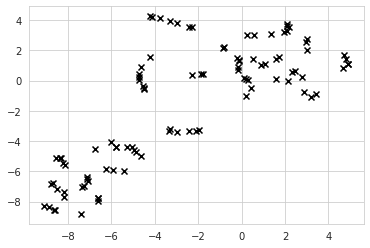

In [24]:
# sample 100 data

# ms-mdaer
source_after_tsne_data = []
for i in range(len(features_tsne_source)):
    source_after_tsne_data.append(sample_from_matrix(features_tsne_source[i], 100))
trans_t_data = tsne.fit_transform(target_tsne_data)
plt.scatter(trans_t_data[:,0], trans_t_data[:,1], marker="x", c='black')

# dan
# source_after_tsne_data = sample_from_matrix(feature_tsne_source, 1400)


In [25]:
# ms-mdaer
target_after_tsne_data = []
for i in range(len(features_tsne_source)):
    target_after_tsne_data.append(sample_from_matrix(features_tsne_target[i], 100))

# dan
# target_after_tsne_data = sample_from_matrix(feature_tsne_target, 1400)


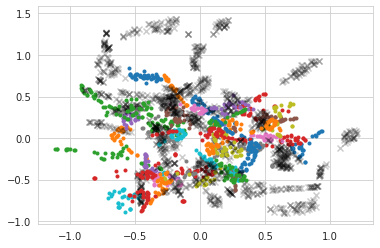

In [27]:
# ms-mdaer
for i in range(len(source_after_tsne_data)):
    trans_data = tsne.fit_transform(source_after_tsne_data[i].cpu().data.numpy())
    trans_data = norm_tsne(trans_data)
    plt.scatter(trans_data[:,0], trans_data[:,1], marker=".")
    trans_t_data = tsne.fit_transform(target_after_tsne_data[i].cpu().data.numpy())
    trans_t_data = norm_tsne(trans_t_data)
    plt.scatter(trans_t_data[:,0], trans_t_data[:,1], marker="x", c='black', alpha=0.2)

# dan
# trans_data = tsne.fit_transform(source_after_tsne_data.cpu().data.numpy())
# trans_data = norm_tsne(trans_data)
# # plt.scatter(trans_data[:,0], trans_data[:,1], marker=".", c='darkseagreen')
# plt.scatter(trans_data[:,0], trans_data[:,1], marker=".")
# trans_t_data = tsne.fit_transform(target_after_tsne_data.cpu().data.numpy())
# trans_t_data = norm_tsne(trans_t_data)
# plt.scatter(trans_t_data[:,0], trans_t_data[:,1], marker="x", c='black', alpha=0.2)